In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


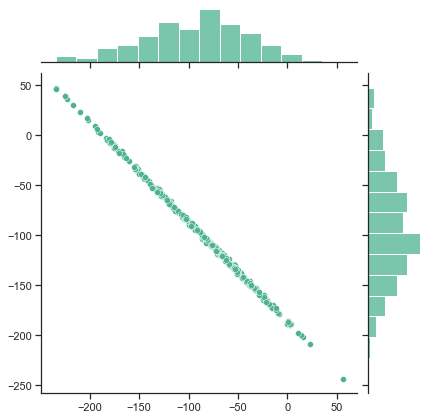

In [224]:
import seaborn as sns
sns.set(style="ticks")
sns.jointplot(x1-x2, x1+x2, color="#4CB391")

In [7]:
shots = 300  # Number of samples

signal = (1+1j)*np.zeros(shots)
idler = (1+1j)*np.zeros(shots)
#theta = np.random.rand(shots)

for i in range(shots):
    
    prog_2mode= sf.Program(2)
    with prog_2mode.context as q:
        sf.ops.S2gate(5,0) | (q[0],q[1])
        sf.ops.ThermalLossChannel(0.1,10) | q[0]
     
        sf.ops.MeasureHD | q[0]
        sf.ops.MeasureHD | q[1]

    eng = sf.Engine("bosonic")
    results = eng.run(prog_2mode)
    eng = sf.Engine("bosonic")
    results = eng.run(prog_2mode)
    
    samples = results.all_samples
    
    signal[i] = samples[0][0]
    idler[i] = samples[1][0]

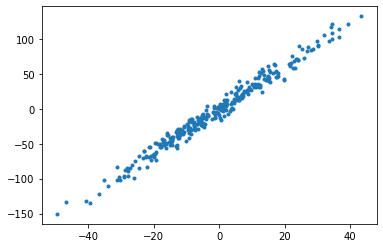

In [8]:
plt.plot(signal.real,idler.real,'.')

In [124]:
def TwoModeSqueezedHD(Ns,t,nth,shots):
    
    """
    Function that performs sensing using two-mode squeezing and performing heterodyne measurements
    
    Args:
    
        Ns (float) : Average number of photons in the #1 mode
        t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel
        shots (integer) : number of repeated iid measurements to perform
    
    Returns:
    
        list, list (complex,complex): returns the complex signal <X>+i<P> of both modes
    
    
    
    """
    
    s1 = (1+1j)*np.zeros(shots)
    s2 = (1+1j)*np.zeros(shots)
    
    r = np.arcsinh(np.sqrt(Ns))
    
    for i in range(shots):
        prog= sf.Program(2)
        
        with prog.context as q:
        
            sf.ops.S2gate(r,0) | (q[0],q[1]) # State preparation
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1
            sf.ops.MeasureHD | q[1] # Het. Msmnt of signal 2

        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
    
        #Collecting the samples
        samples = results.all_samples
    
        #Creating the measurement records
        s1[i] = samples[0][0]
        s2[i] = samples[1][0]
    
    # Interation over number of shots is done, outputing the records
    
    return s1,s2

def SNR(op0, op1):
    """ Function that evaluates the signal-to-noise ratio of a given operator depending 
    on the msmt statistics on a binary outcome repeated over N independant and inditically distributed measurements.
    
        We define SNR as
        SNR = |<op1> - <op0>|^2 / (Var[op0]+ Var[op1])
        
        <x> statistical average of operator x
        Var[x] denotes the variance of x
        
    Args:
    
        op0, op1 (complex array length N ) : array N elements with the expectation values over N iids of an operator op given the binary outcome 0 or 1
        
    
    Returns:
    
        float: SNR calculation from the above equation
        
        
        
    
    """
    result = np.abs(np.mean(op1) - np.mean(op0))**2/(np.var(op1)+np.var(op0))
    
    return result




Ok so now, we need to have a binary hypothesis test:

Target absent : H = 0 s1 is completely lost and totally replaced by atmospheric noise. Channel transmittivity t =0

Target present : H =1 s1 is reflected with probability r = 1 - t, where t is the channel transmittivity



In [178]:
#Preparation parameters
Ns = 1000

#Loss Channel parameters
nth=1
t= 1

# Number of measurements
shots=5000



#Target Absent 
s10 = (1+1j)*np.zeros(shots)
s20 = (1+1j)*np.zeros(shots)

s10,s20 = TwoModeSqueezedHD(Ns,0,nth,shots)


# Target Present
s11 = (1+1j)*np.zeros(shots)
s21 = (1+1j)*np.zeros(shots)

s11,s21 = TwoModeSqueezedHD(Ns,t,nth,shots)

In [179]:
#Simple fact checking that we have zero-mean states with high variance
#Ideally: the average value and variance should be about the same regardless of the status of the target (high loss, high noise limit)
print(np.abs(np.mean(s10)),np.abs(np.mean(s20)),np.var(s10),np.var(s20))
print(np.abs(np.mean(s11)),np.abs(np.mean(s21)),np.var(s11),np.var(s21))

0.03932647038334047 0.37920869863494544 2.005980564671225 996.8954133680157
0.18193044390243307 0.18022847975829603 1005.6506710474199 1006.2952161258809


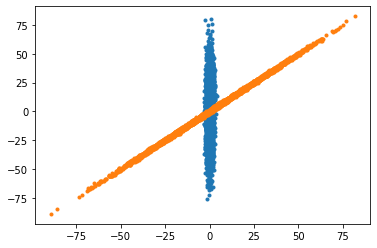

In [180]:
plt.plot(s10.real,s20.real,'.')
plt.plot(s11.real,s21.real,'.')

In [181]:
Mop0=s10*s20
Mop1=s11*s21

print(np.abs(np.mean(Mop0)),np.var(Mop0),np.abs(np.mean(Mop0))**2/np.var(Mop0))
print(np.abs(np.mean(Mop1)),np.var(Mop1),np.abs(np.mean(Mop1))**2/np.var(Mop1))

1.0508620326002822 1985.8046997391534 0.0005561025269533575
1005.5028804617925 1022595.9239478763 0.9886955530916983


In [182]:
SNR(Mop0,Mop1)

0.9847835770994477

2.6252882696439594 10.337285266934916
2.399937378840935 7.740014281684763
